In [1]:
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

In [2]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm_notebook as tqdm

from IPython import display

In [3]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
  def __init__(self, name='cholec80', batch_size=64, test_batch_size=1000,
            epochs=15, lr=0.01/20, optimizer='adam', momentum=0.5,
            seed=1, log_interval=100, dataset='cholec80',
            data_dir='./data', model='DenseNetPretrainedFC',
            cuda=True):
    self.name = name # name for this training run. Don't use spaces.
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size # Input batch size for testing
    self.epochs = epochs # Number of epochs to train
    self.lr = lr # Learning rate
    self.optimizer = optimizer # sgd/p1sgd/adam/rms_prop
    self.momentum = momentum # SGD Momentum
    self.seed = seed # Random seed
    self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
    self.dataset = dataset # mnist/fashion_mnist
    self.data_dir = data_dir
    self.model = model
    self.cuda = cuda and torch.cuda.is_available()

In [ ]:
# creating cholec80 dataset class

class cholec80(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        """
        Args: 
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
def prepare_dataset(args):
    # choose the dataset
    if args.dataset == 'cholec80':
        DatasetClass = cholec80
        print("using cholec80")
    else:
        raise ValueError('unknown dataset: ' + args.dataset +
                ' try mnist or fashion_mnist')

    def time_stamp(fname, fmt='%m-%d-%H-%M_{fname}'):
        return datetime.datetime.now().strftime(fmt).format(fname=fname)
        
    training_run_name = time_stamp(args.dataset + '_' + args.name)

    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

    # Create the dataset: mnist or fasion_mnist
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    training_run_dir = os.path.join(args.data_dir, training_run_name)
    train_dataset = DatasetClass(
        dataset_dir, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    test_dataset = DatasetClass(
        dataset_dir, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    if not os.path.exists(training_run_dir):
        os.makedirs(training_run_dir)

    return train_loader, test_loader, train_dataset, test_dataset, training_run_dir

using mnist


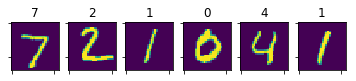

In [29]:
# visualize some images

args = Args()
_, _, _, test_dataset, _ = prepare_dataset(args)
images = test_dataset.test_data[:6]
labels = test_dataset.test_labels[:6]
fig, axes = plt.subplots(1,6)
for axis, img, lbl in zip(axes, images, labels):
    axis.imshow(img)
    axis.set_title(str(lbl.item()))
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()


In [30]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch

    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward prediction step
        output = model(data)
        loss = F.nll_loss(output, target)

        # Backpropagation step
        loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        pred = output.data.max(1)[1]  

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pred
        accuracy = matches.float().mean()
        correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.data[0])
            train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [31]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').data  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += (target == pred).float().sum()

    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

In [33]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)

    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model == 'default' or args.model == 'P2Q7DefaultChannelsNet':
        model = Net()
    elif args.model in globals():
        model = globals()[args.model]()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif args.optimizer == 'rms_prop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        # train for 1 epoch
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
        torch.save(model.state_dict(), 'ultimate_model.pt')
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6)
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(str(lbl.data))
        axis.set_yticklabels([])
        axis.set_xticklabels([])
            
    if args.dataset == 'fashion_mnist' and val_acc > 0.92 and val_acc <= 1.0:
        print("Congratulations, you beat the Question 13 minimum of 92"
            "with ({:.2f}%) validation accuracy!".format(val_acc))

Training:   0%|          | 0/938 [00:00<?, ?it/s]

using mnist


/home/adit/.virtualenvs/DeepLearning/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/adit/.virtualenvs/DeepLearning/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Epoch: 2 loss: 1.8312, acc: 0.69:   0%|          | 1/938 [00:00<02:57,  5.28it/s]


Epoch: 1 validation test results - Average val_loss: 1.8363, val_acc: 7162.0/10000 (71.62%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 1.0243, val_acc: 8189.0/10000 (81.89%)


Epoch: 4 loss: 0.6923, acc: 0.84:   0%|          | 1/938 [00:00<02:43,  5.74it/s]


Epoch: 3 validation test results - Average val_loss: 0.5195, val_acc: 9079.0/10000 (90.79%)


Epoch: 5 loss: 0.4169, acc: 0.88:   0%|          | 1/938 [00:00<02:47,  5.59it/s]


Epoch: 4 validation test results - Average val_loss: 0.3122, val_acc: 9367.0/10000 (93.67%)


Epoch: 6 loss: 0.3023, acc: 0.94:   0%|          | 1/938 [00:00<02:35,  6.03it/s]


Epoch: 5 validation test results - Average val_loss: 0.2148, val_acc: 9505.0/10000 (95.05%)


Epoch: 7 loss: 0.2133, acc: 0.94:   0%|          | 1/938 [00:00<02:45,  5.68it/s]


Epoch: 6 validation test results - Average val_loss: 0.1669, val_acc: 9593.0/10000 (95.93%)


Epoch: 8 loss: 0.1929, acc: 0.97:   0%|          | 1/938 [00:00<02:32,  6.13it/s]


Epoch: 7 validation test results - Average val_loss: 0.1388, val_acc: 9647.0/10000 (96.47%)


Epoch: 9 loss: 0.1377, acc: 0.97:   0%|          | 1/938 [00:00<02:30,  6.21it/s]


Epoch: 8 validation test results - Average val_loss: 0.1197, val_acc: 9692.0/10000 (96.92%)


Epoch: 10 loss: 0.1031, acc: 0.98:   0%|          | 1/938 [00:00<02:34,  6.08it/s]


Epoch: 9 validation test results - Average val_loss: 0.1054, val_acc: 9725.0/10000 (97.25%)


Epoch: 11 loss: 0.3053, acc: 0.92:   0%|          | 1/938 [00:00<02:39,  5.87it/s]


Epoch: 10 validation test results - Average val_loss: 0.0939, val_acc: 9748.0/10000 (97.48%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 validation test results - Average val_loss: 0.0864, val_acc: 9766.0/10000 (97.66%)


Epoch: 13 loss: 0.2353, acc: 0.95:   0%|          | 1/938 [00:00<02:53,  5.40it/s]


Epoch: 12 validation test results - Average val_loss: 0.0778, val_acc: 9783.0/10000 (97.83%)


Epoch: 14 loss: 0.0607, acc: 0.98:   0%|          | 1/938 [00:00<02:41,  5.82it/s]


Epoch: 13 validation test results - Average val_loss: 0.0721, val_acc: 9798.0/10000 (97.98%)


Epoch: 15 loss: 0.1006, acc: 0.97:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 validation test results - Average val_loss: 0.0679, val_acc: 9809.0/10000 (98.09%)


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]



Epoch: 15 validation test results - Average val_loss: 0.0635, val_acc: 9822.0/10000 (98.22%)


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:204

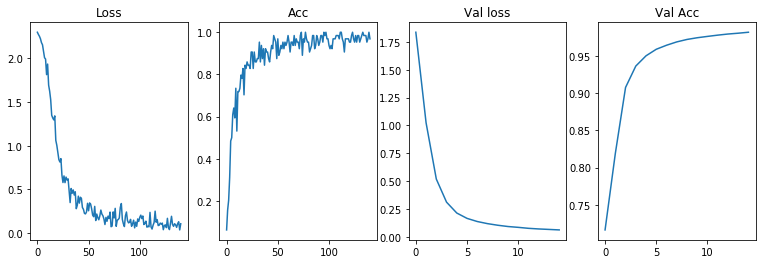

In [34]:
run_experiment(Args())

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

using mnist


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]



Epoch: 0 validation test results - Average val_loss: 7.9233, val_acc: 1069.0/10000 (10.69%)


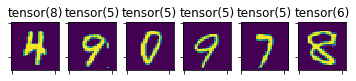

In [25]:
ultimate_fashion_model = P2Q13UltimateNet()
ultimate_fashion_model.load_state_dict(torch.load('ultimate_model.pt'))
ultimate_fashion_model.eval()

train_loader, test_loader, _, _, run_path = prepare_dataset(args)
val_acc = test(ultimate_fashion_model, test_loader, 0, total_minibatch_count=0, val_losses=[], val_accs=[])

# Predict and Test
images, labels = next(iter(test_loader))
if args.cuda:
    images, labels = images.cuda(), labels.cuda()
output = ultimate_fashion_model(images)
predicted = torch.max(output, 1)[1]
fig, axes = plt.subplots(1,6)
for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
    if i > 5:
        break
    img = img.permute(1,2,0).squeeze()
    axis.imshow(img)
    axis.set_title(str(lbl.data))
    axis.set_yticklabels([])
    axis.set_xticklabels([])